In [8]:
import tensorflow as tf
# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:

class DatasetPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.target_name = 'cardio'
        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path, sep=";")
        self.data.drop("id", axis=1, inplace=True)
        self.data.drop_duplicates(inplace=True)
        self.data["bmi"] = self.data["weight"] / (self.data["height"]/100)**2
        out_filter = ((self.data["ap_hi"] > 250) | (self.data["ap_lo"] > 200))
        self.data = self.data[~out_filter]
        out_filter2 = ((self.data["ap_hi"] < 0) | (self.data["ap_lo"] < 0))
        self.data = self.data[~out_filter2]

    def prepare_data(self):
        self.load_data()
        data_target = self.data[self.target_name]
        self.data = self.data.drop([self.target_name], axis=1)
        
        # Split data into train, test, and validation sets
        train_data, test_data, train_target, test_target = train_test_split(self.data, data_target, test_size=0.2, random_state=0)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(train_data, train_target, test_size=0.25, random_state=0)
        self.X_test, self.X_val, self.y_test, self.y_val = train_test_split(test_data, test_target, test_size=0.5, random_state=0)

        return self.X_train, self.X_test, self.X_val, self.y_train, self.y_test, self.y_val


In [66]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None
    
    def build_ann(self, input_shape, optimizer='adam'):
        # self.model = Sequential()
        # self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        # self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dropout(rate=0.5))
        # self.model.add(Dense(units=96, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=96, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=96, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dropout(rate=0.5))
        # self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        # self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model = Sequential()
        self.model.add(Dense(units=128, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu'))
        # self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [61]:

# Example usage:
data_preprocessor = DatasetPreprocessor("cardio_train.csv")
X_train, X_test, X_val, y_train, y_test, y_val = data_preprocessor.prepare_data()

# Now you can use X_train, X_test, X_val, y_train, y_test, y_val to train and evaluate your neural network model


In [62]:
# Define reduction percentages
reduction_percentage = 0.3

# Reduce the size of the datasets
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [63]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((28969, 12), (4828, 12), (4827, 12), (28969,))

In [71]:
X_train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
15015,16901,2,173,77.0,150,70,1,1,0,0,1,25.727555
37231,19869,1,169,58.0,150,90,1,1,0,0,1,20.307412
40401,16923,1,167,76.0,150,90,3,1,0,0,1,27.250887
2522,19046,1,147,41.0,170,80,1,1,0,0,0,18.973576
13369,18068,1,153,84.0,170,90,2,1,0,0,1,35.883634
...,...,...,...,...,...,...,...,...,...,...,...,...
25881,17541,2,170,69.0,110,70,1,1,0,0,1,23.875433
23816,15274,1,169,67.0,130,90,1,1,0,0,1,23.458562
68112,15449,2,171,84.0,120,80,1,1,1,1,1,28.726788
2618,17578,2,167,70.0,120,80,1,1,1,0,1,25.099502


In [67]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    # 'SGD_momentum': SGD(momentum=0.9),
    # 'Nesterov': SGD(momentum=0.9, nesterov=True),
    # 'RMSprop': tf.keras.optimizers.RMSprop(),
    # 'Adagrad': tf.keras.optimizers.Adagrad(),
    # 'Adadelta': tf.keras.optimizers.Adadelta(),
    # 'Adam': Adam(),
    # 'AMSGrad': Adam(amsgrad=True),
    # 'AdamW': AdamW(weight_decay=1e-4),
    # 'Yogi': Yogi(),
    # 'Nadam': tf.keras.optimizers.Nadam(),
    # 'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
906/906 [==============================] - 5s 5ms/step - loss: 935503.2500 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5014 - lr: 0.0100
Epoch 2/50
906/906 [==============================] - 5s 5ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.5014 - lr: 0.0100
Epoch 3/50
906/906 [==============================] - 4s 5ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.5014 - lr: 0.0100
Epoch 4/50
906/906 [==============================] - 5s 5ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.5014 - lr: 0.0100
Epoch 5/50
906/906 [==============================] - 4s 5ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.5014 - lr: 0.0050
Epoch 6/50
906/906 [==============================] - 4s 5ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5014 - lr: 0.0050
Epoch 7/50
906/906 [========

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.4910, Precision - 0.2411, Recall - 0.4910, F1-score - 0.3234, Convergence Speed - 24 epochs, Training Time - 108.82 seconds


In [56]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Cardiovascular"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Cardiovascular,24831,12,int64,FNN,SGD,0.487917,0.238063,0.487917,0.319995,33,137.342949,62474.003906,0.693091


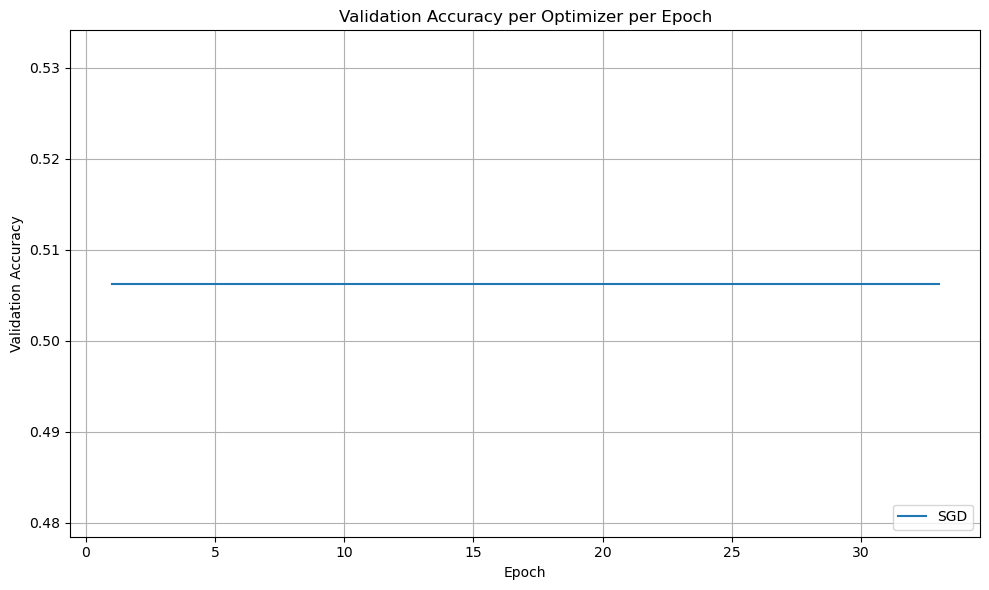

In [58]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


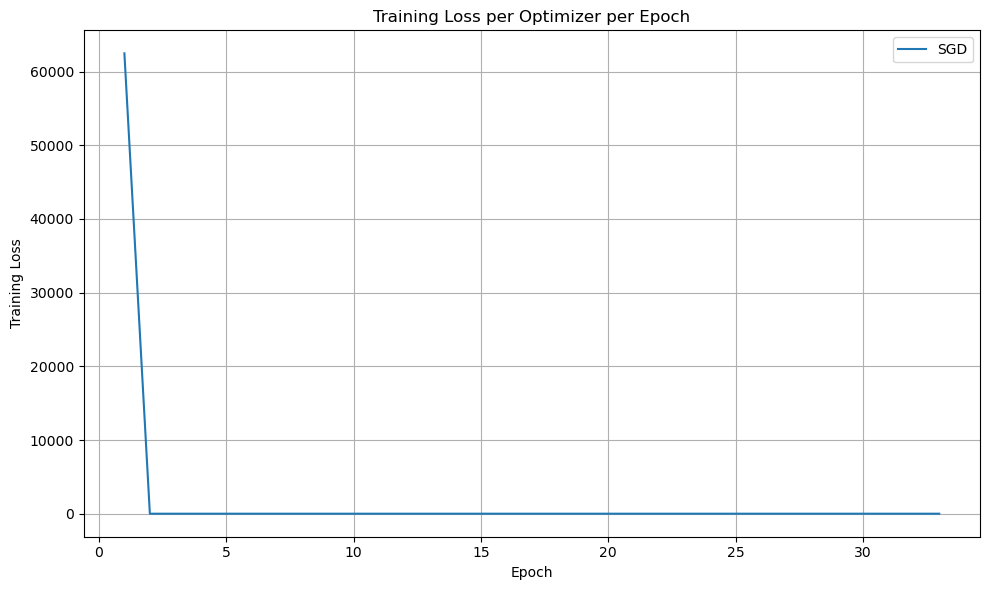

In [59]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
final_df.to_csv('cardiovascular_nn_r(3).csv', index=False)

############################# Before Presentation ########################################

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
import time
import matplotlib.pyplot as plt
class DatasetPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.target_name = 'cardio'
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path, sep=";")
        self.data.drop("id", axis=1, inplace=True)
        self.data.drop_duplicates(inplace=True)
        self.data["bmi"] = self.data["weight"] / (self.data["height"]/100)**2
        out_filter = ((self.data["ap_hi"] > 250) | (self.data["ap_lo"] > 200))
        self.data = self.data[~out_filter]
        out_filter2 = ((self.data["ap_hi"] < 0) | (self.data["ap_lo"] < 0))
        self.data = self.data[~out_filter2]

    def prepare_data(self):
        self.load_data()
        data_target = self.data[self.target_name]
        self.data = self.data.drop([self.target_name], axis=1)
        train, test, target, target_test = train_test_split(self.data, data_target, test_size=0.2, random_state=0)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(train, target, test_size=0.2, random_state=0)

In [2]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None
    
    def build_ann(self, input_shape, optimizer='adam'):
        self.model = Sequential()
        self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

In [12]:
file_path = 'cardio_train.csv'
data_preprocessor = DatasetPreprocessor(file_path)
data_preprocessor.prepare_data()

Training model with SGD optimizer...
Epoch 1/2
1380/1380 [==============================] - 9s 6ms/step - loss: 5277.7236 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 2/2
345/345 [==============================] - 1s 3ms/step - loss: 0.6930 - accuracy: 0.5097
Training model with Adam optimizer...
Epoch 1/2
1380/1380 [==============================] - 10s 7ms/step - loss: 35.7352 - accuracy: 0.5053 - val_loss: 0.6931 - val_accuracy: 0.5097
Epoch 2/2
345/345 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.5097
Training model with RMSprop optimizer...
Epoch 1/2
1380/1380 [==============================] - 10s 7ms/step - loss: 26.4396 - accuracy: 0.5032 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 2/2
345/345 [==============================] - 1s 3ms/step - loss: 0.6930 - accuracy: 0.5097
Training model with Adagrad optimizer...
Epoch 1/2
1380/1380 [==============================] - 11s 7ms/step - loss: 459.5341 - accuracy: 0.4993 - val_

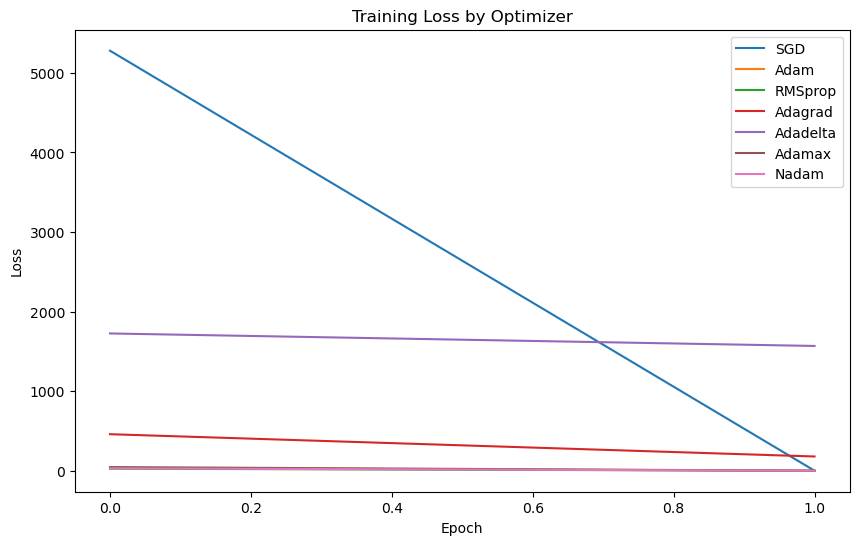

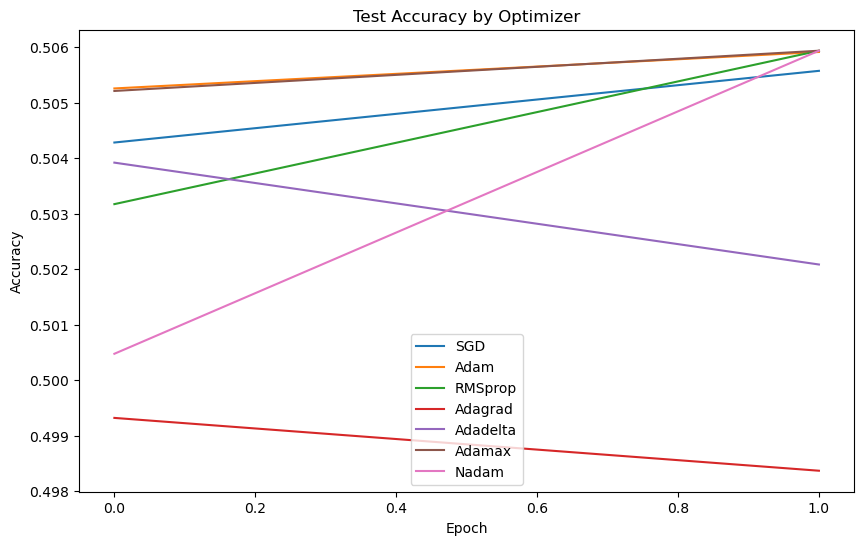

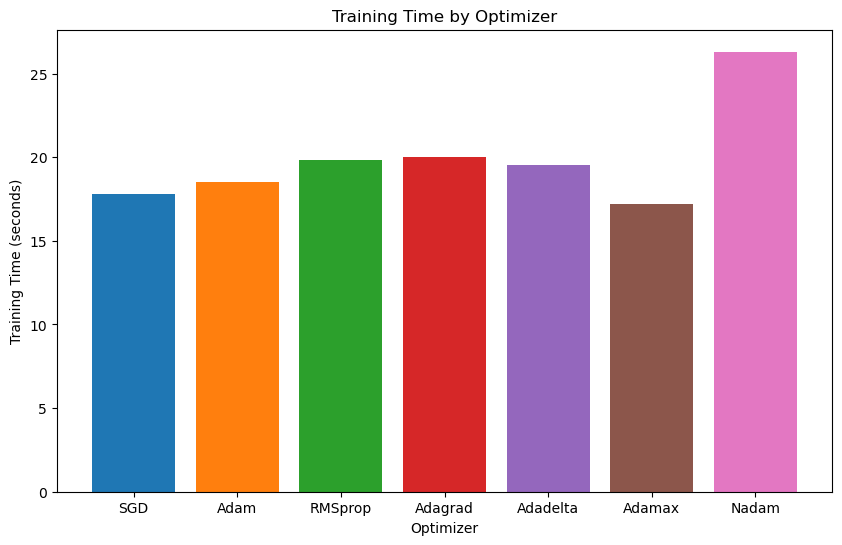

In [13]:
# List of optimizers to test for NN
optimizers = {
    'SGD': 'SGD',
    'Adam': 'adam',
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam'
}

results = {}

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(data_preprocessor.X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = model_instance.train(data_preprocessor.X_train, data_preprocessor.y_train, epochs=2, batch_size=32, validation_data=(data_preprocessor.X_test, data_preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(data_preprocessor.X_test, data_preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [6]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Nadam
Accuracy: 0.5097
Loss: 0.6931
Shortest Training Time: 23.32 seconds


Comparison of Optimizers:
          accuracy        loss  training_time
SGD       0.509696    0.693104      18.116941
Adam      0.509696    0.693120      20.242384
RMSprop   0.509696    0.693117      21.515473
Adagrad   0.490304  128.914536      17.814607
Adadelta  0.490304  863.169983      17.977161
Adamax    0.509696    0.693119      15.307178
Nadam     0.509696    0.693091      23.322750


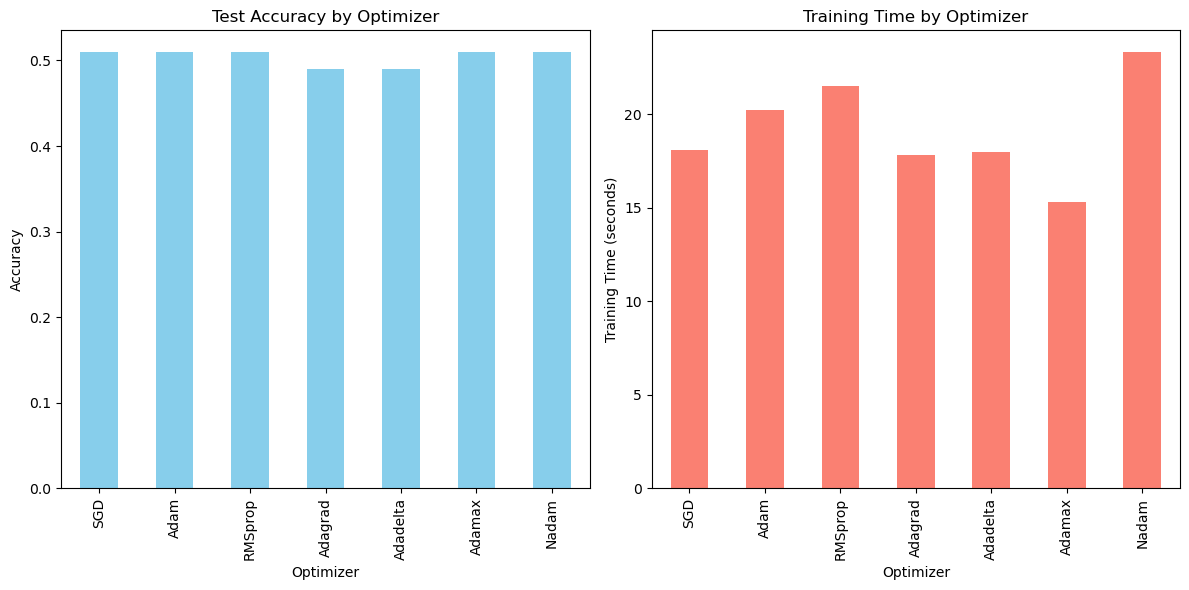

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [1]:
!pip install tensorflow-addons

In [2]:
# from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

Training model with SGD optimizer...
Epoch 1/100
1380/1380 [==============================] - 11s 5ms/step - loss: 273397.8750 - accuracy: 0.5054 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 2/100
1380/1380 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 3/100
1380/1380 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 4/100
1380/1380 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 5/100
1380/1380 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 6/100
1380/1380 [==============================] - 7s 5ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 7/100
1380/1380 [==============================] - 7s 5ms/step - loss: 0.6931 - a

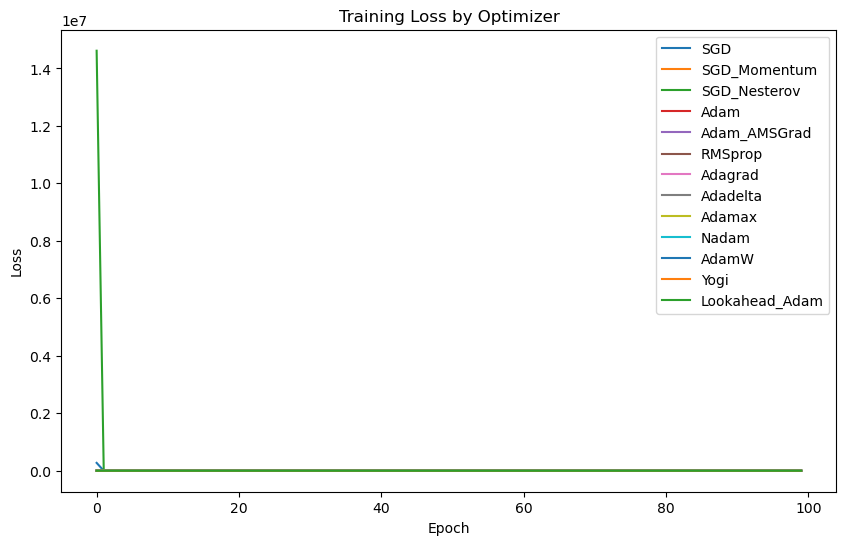

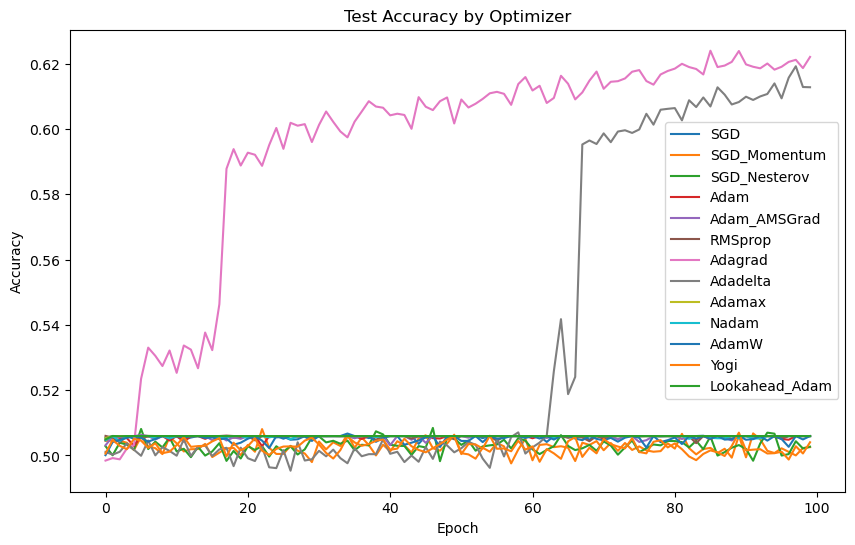

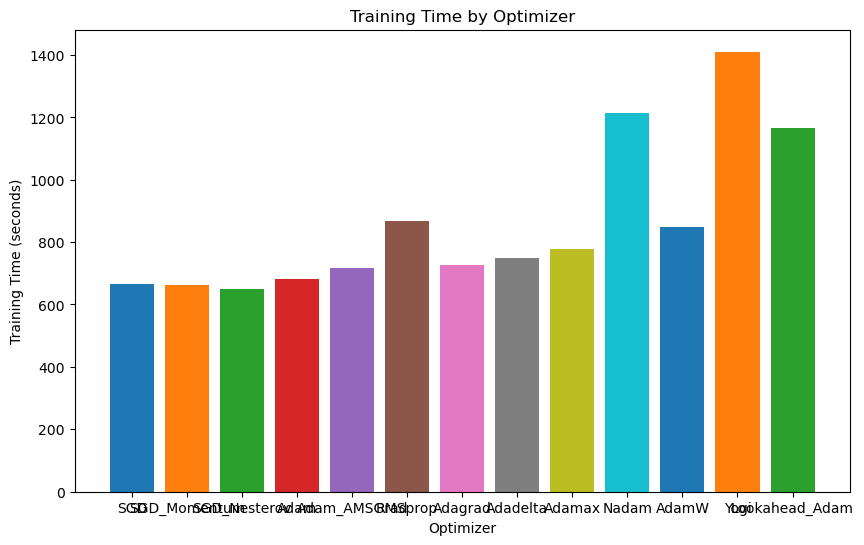

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow_addons.optimizers import Yogi
# from tensorflow_addons.optimizers import AdaBound, AMSGrad
# from tensorflow_addons.optimizers import AMSGrad
import time
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Adam

class DatasetPreprocessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.target_name = 'cardio'
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path, sep=";")
        self.data.drop("id", axis=1, inplace=True)
        self.data.drop_duplicates(inplace=True)
        self.data["bmi"] = self.data["weight"] / (self.data["height"]/100)**2
        out_filter = ((self.data["ap_hi"] > 250) | (self.data["ap_lo"] > 200))
        self.data = self.data[~out_filter]
        out_filter2 = ((self.data["ap_hi"] < 0) | (self.data["ap_lo"] < 0))
        self.data = self.data[~out_filter2]

    def prepare_data(self):
        self.load_data()
        data_target = self.data[self.target_name]
        self.data = self.data.drop([self.target_name], axis=1)
        train, test, target, target_test = train_test_split(self.data, data_target, test_size=0.2, random_state=0)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(train, target, test_size=0.2, random_state=0)

class NeuralNetworkModel:
    def __init__(self):
        self.model = None
    
    def build_ann(self, input_shape, optimizer='adam'):
        self.model = Sequential()
        self.model.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(input_shape,)))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

file_path = 'cardio_train.csv'
data_preprocessor = DatasetPreprocessor(file_path)
data_preprocessor.prepare_data()

# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_Momentum': SGD(momentum=0.9),
    'SGD_Nesterov': SGD(momentum=0.9, nesterov=True),
    'Adam': Adam(),
    'Adam_AMSGrad': Adam(amsgrad=True),
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam',
    'AdamW': tfa.optimizers.AdamW(weight_decay=0.001),
    'Yogi': tfa.optimizers.Yogi(),
    'Lookahead_Adam': tfa.optimizers.Lookahead(Adam(), sync_period=6, slow_step_size=0.5)
}

results = {}

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    if isinstance(optimizer, str):
        optimizer_name = optimizer
    else:
        optimizer_name = name
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(data_preprocessor.X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = model_instance.train(data_preprocessor.X_train, data_preprocessor.y_train, epochs=100, batch_size=32, validation_data=(data_preprocessor.X_test, data_preprocessor.y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(data_preprocessor.X_test, data_preprocessor.y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}

# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()


In [5]:
# Assumption: The 'results' dictionary has been filled with training data as in your original code.

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]  # Get the last loss value
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for name, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy or (accuracy == best_accuracy and loss < lowest_loss):
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = name
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = name

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")


Best performing optimizer: Adagrad
Accuracy: 0.6771
Loss: 0.6657
Shortest Training Time: 726.14 seconds


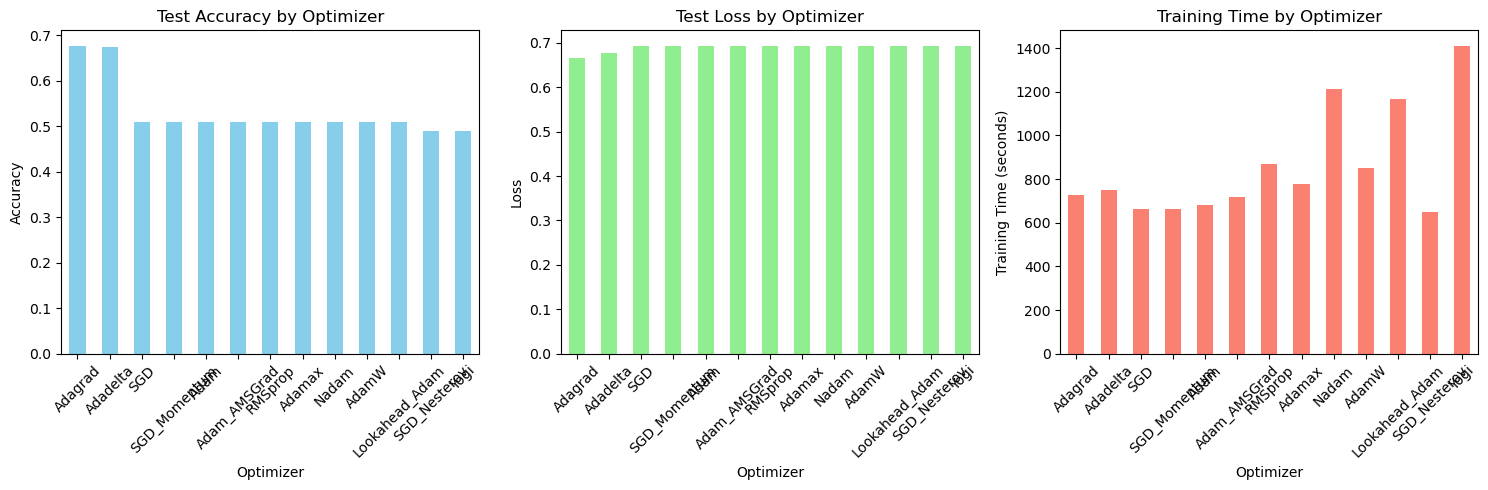

Comparison of Optimizers:
                accuracy      loss  training_time
Adagrad         0.677148  0.665668     726.138686
Adadelta        0.674339  0.675999     747.783609
SGD             0.509696  0.693113     664.435568
SGD_Momentum    0.509696  0.693298     663.451553
Adam            0.509696  0.693120     682.301003
Adam_AMSGrad    0.509696  0.693116     717.133879
RMSprop         0.509696  0.693108     868.537387
Adamax          0.509696  0.693090     778.294394
Nadam           0.509696  0.693105    1212.408502
AdamW           0.509696  0.693102     849.374399
Lookahead_Adam  0.509696  0.693094    1164.494269
SGD_Nesterov    0.490304  0.693289     650.461270
Yogi            0.490304  0.693136    1410.722629


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the 'results' dictionary is populated with the training results from the earlier code

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for name, result in results.items():
    accuracy = result['test_accuracy']
    loss_history = result['history'].history['loss']
    if len(loss_history) > 0:  # Ensure there is at least one loss value
        loss = loss_history[-1]  # Get the last loss value
    else:
        loss = None
    training_time = result['training_time']
    optimizer_metrics[name] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows
df.sort_values('accuracy', ascending=False, inplace=True)  # Sort by accuracy in descending order

# Step 3: Plot the comparison using a graph
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
df['loss'].plot(kind='bar', color='lightgreen')
plt.title('Test Loss by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.xticks(rotation=45)
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()

# Step 4: Optionally, print the DataFrame for a text-based comparison
print("Comparison of Optimizers:")
print(df)
